#**Section 1.3 Neural network training approach on the example of Logistic regression**

**Preface**

The purpose of this chapter is to show how neural networks are trained, using a familiar algorithm. In this case, we decided to use the **logistic regression** - algorithm, that allows us to solve the classification problem. This choice is justified by the following reasons:

- **sigmoid function** of the logistic regression is one of the possible activation functions used to  compress values inside the layers in some range ([0, 1] in the case of sigmoid). In the light of classifictaion problem it gives us propabilities of the event; In neural networks it is used to compress the information and pass it to the next layers.

- **cost function** of the logit model - the indicator, which shows us how well the model is trained in different phases (the lower - the better); The generalized verision of it is known as Cross-Entropy function, where the choise is not binomial. It is commonly used in neural networks, so it is useful to explore the former version of it.


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import style

First of all, we need to load our data. In order to cover all the aspects described in this section, a specific dataset has been created. It consists of 4 columns. Variables we are insterested in are "x1", "x2", "y".

In [ ]:
#import data in google colab; file: "datalog.csv"
files.upload() 

#read it as a dataframe;
df = pd.read_csv("data_logit.csv")
df.head(5)

Saving data_logit.csv to data_logit.csv


,x1,x2,y,X1plusX2
0,89.946963,72.091781,1,162.038744
1,77.111425,75.206589,1,152.318014
2,71.854053,80.549965,1,152.404018
3,67.182350,97.026782,1,164.209131
4,71.087755,71.098405,1,142.186160


A common approach is to perform some **data transformations** before model training. Optimization algorithms such as gradient descent require data to be scaled to provide more efficient calculations.

Because the scale of the data is different from case to case, this can significantly affect the step size (even if we use a learning rate, like 0.01). The difference in ranges of features will cause disproportionate steps during iteration. This, in turn, can increase training time and make it more computationally expensive.

There are **two common approaches** we can take to prevent this: 
*   **Normalization**
*   **Standardization**

We won't go into details (this is out of the scope of this section), but it is very useful to take a time and  learn more about them.


Thus, we need to convert some columns to numpy arrays in order to provide these changes:

In [ ]:
x_np = df[["x1", "x2"]].to_numpy()
y_np = df['y'].to_numpy()

But before we start, let's divide our data into two groups: training and test sets. This will allow us to test the performance of the model later.

In [ ]:
#The proportion of training/test groups is 80/20 respectively.
x_train, x_test, y_train, y_test = train_test_split(x_np, y_np, test_size=0.2, random_state=120)

Now, we need to standardize features by removing the mean and scaling to unit variance.

In [ ]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

**fit_transform()** is used to find the standartization parameters on the basis of training set (in our case: ***mean*** and ***standard deviation***). Hence, we may use them later to transform a test set for futher calculations.

Note, that the parameters are computed with the respect to the columns. We can simply check it out: 

In [ ]:
#Here we will use our initial "x", that contains all the data about predictors;
sc_example= StandardScaler()
x_empl = sc_example.fit_transform(x_np)

print(f"mean of sc_example: {sc_example.mean_[0]}; manually: {np.mean(x_np[:,0])}")
print(f"sd of sc_example: {sc_example.var_[0]**0.5}; manually: {np.std(x_np[:,0])}") #sd is calculated for the population, to fix that, we need set the degrees of freedom;

mean of sc_example: 70.91320082552684; manually: 70.91320082552684
sd of sc_example: 10.342699121189455; manually: 10.342699121189455


In this section, we will recreate the optimization process manually. The reason for this is that we want to show the background of the model's learning, the math behind it, to create a basic intuition.

We also want to avoid automated functions where possible and go into more detail to show the background of well-known commands. But before we start, we need to provide some changes: add the column for constant in our dataset - inside the **x_train** and **x_test** respectively; 

To do this, we will create new variables (the existing ones will be used later);

In [ ]:
x_train = np.insert(x_train, 0, 1, axis=1)
x_test = np.insert(x_test, 0, 1, axis=1)

Then we convert our arrays to the torch tensors:

In [ ]:
x_train_t = torch.from_numpy(x_train.astype(np.float32))
x_test_t = torch.from_numpy(x_test.astype(np.float32)) 
y_train_t = torch.from_numpy(y_train.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))

***Theory moment***

Each algorithm has its own steps that we need to go through in order to achieve parameter optimization. Due to the fact that we are dealing with a huge number of parameters, it has become a little difficult to find a gradient for each with respect to the Loss function. This is why, in the world of the neural networks, the phases of model calculus are represented by the **computational graph**, where each node corresponds to a specific mathematical operation. This approach eliminates such a problem and provides the intuitiveness of  the model training (forward and back propagation), simplifies the mathematics.

The big advantage is that we can apply the same technique to other algorithms with fewer parameters. In our case, we will illustrate this with the help of logistic regression. The computational graph of it is shown below:



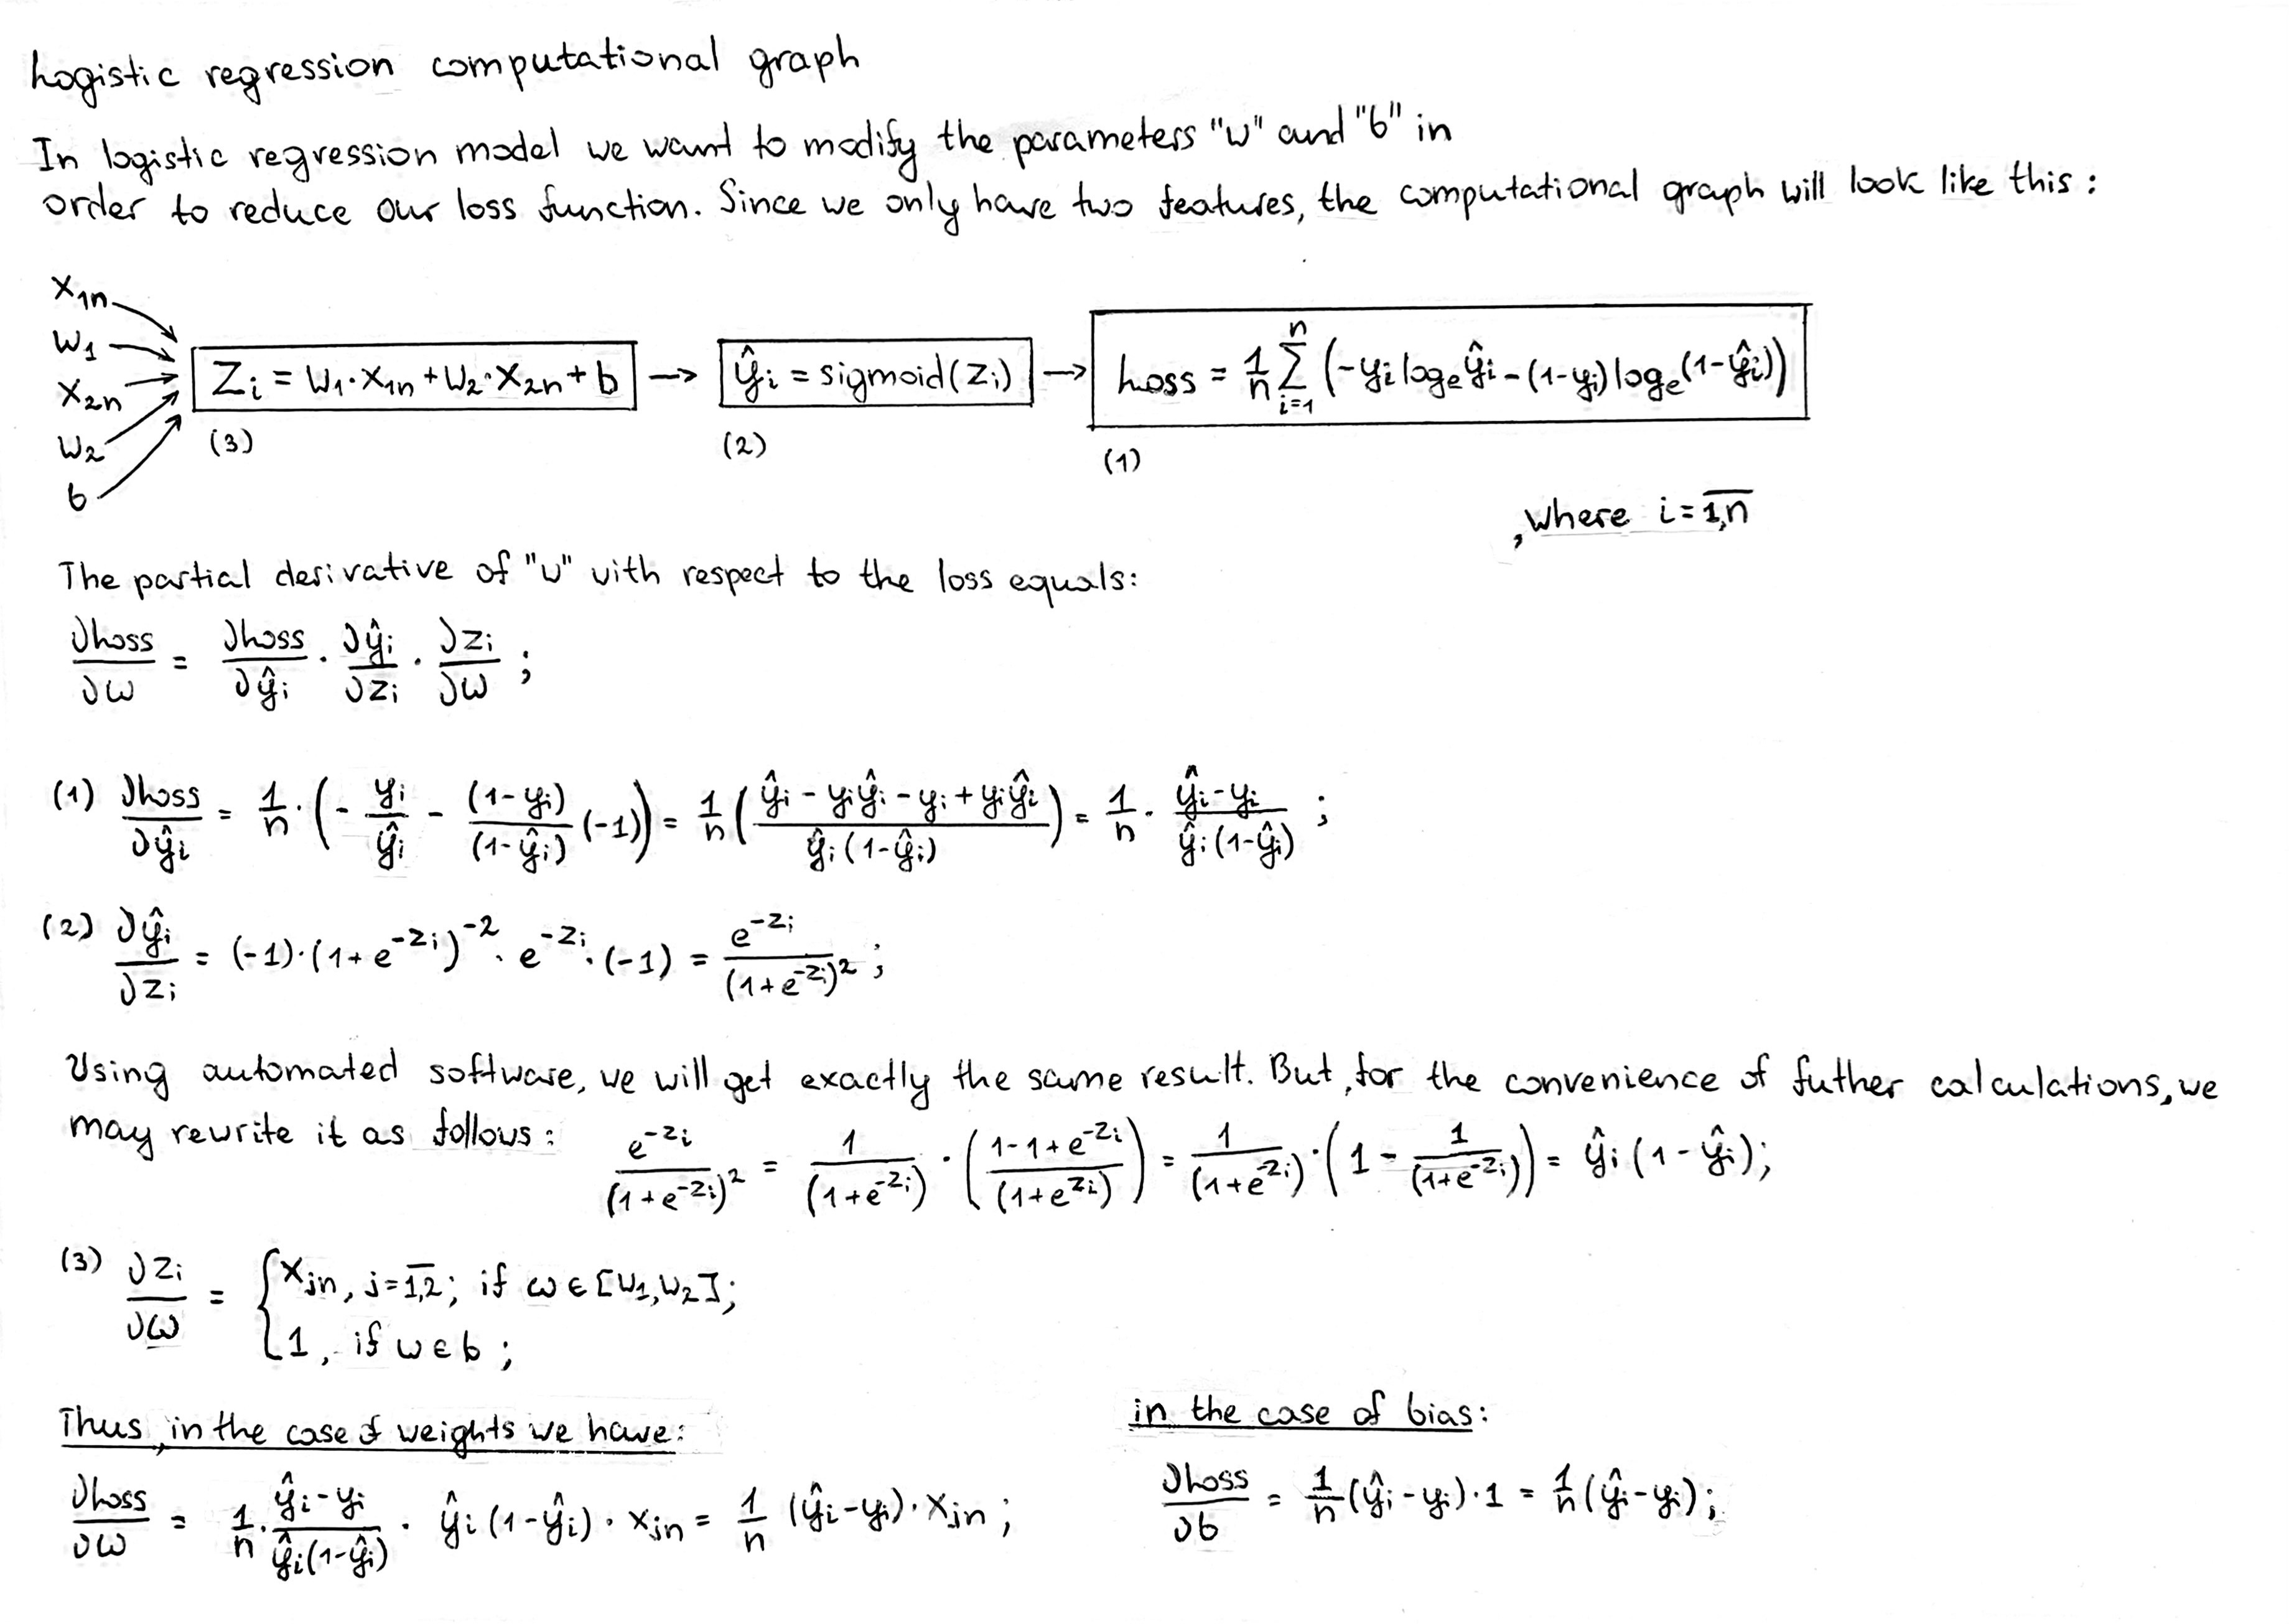

In fact, **backpropagation** is nothing more than a chain rule in the opposite direction. The reason for using it is that it allows us to find partial derivatives for all weights at a time. Otherwise, we would have to calculate them separately for each weight (in the case of forward path).

In the light of logistic regression, the search for parameters does not look computationally expensive. But what about other algorithms?

On practice, we need to find the optimal approach to gain the same results in more efficient way. The solution is the **Product of Jacobian matrices**. The idea behind this is that we find the derivatives of each node with respect to the parameters for all observations, collect them into matrices and then multiply them in reverse order. This allows us to vectorize the data and achieve the desired result due to the beauty of matrix multiplication.


The thing we have to take into account is the shape of the object we want to take a gradient of. In the example below, we did the Jacobian product manually:

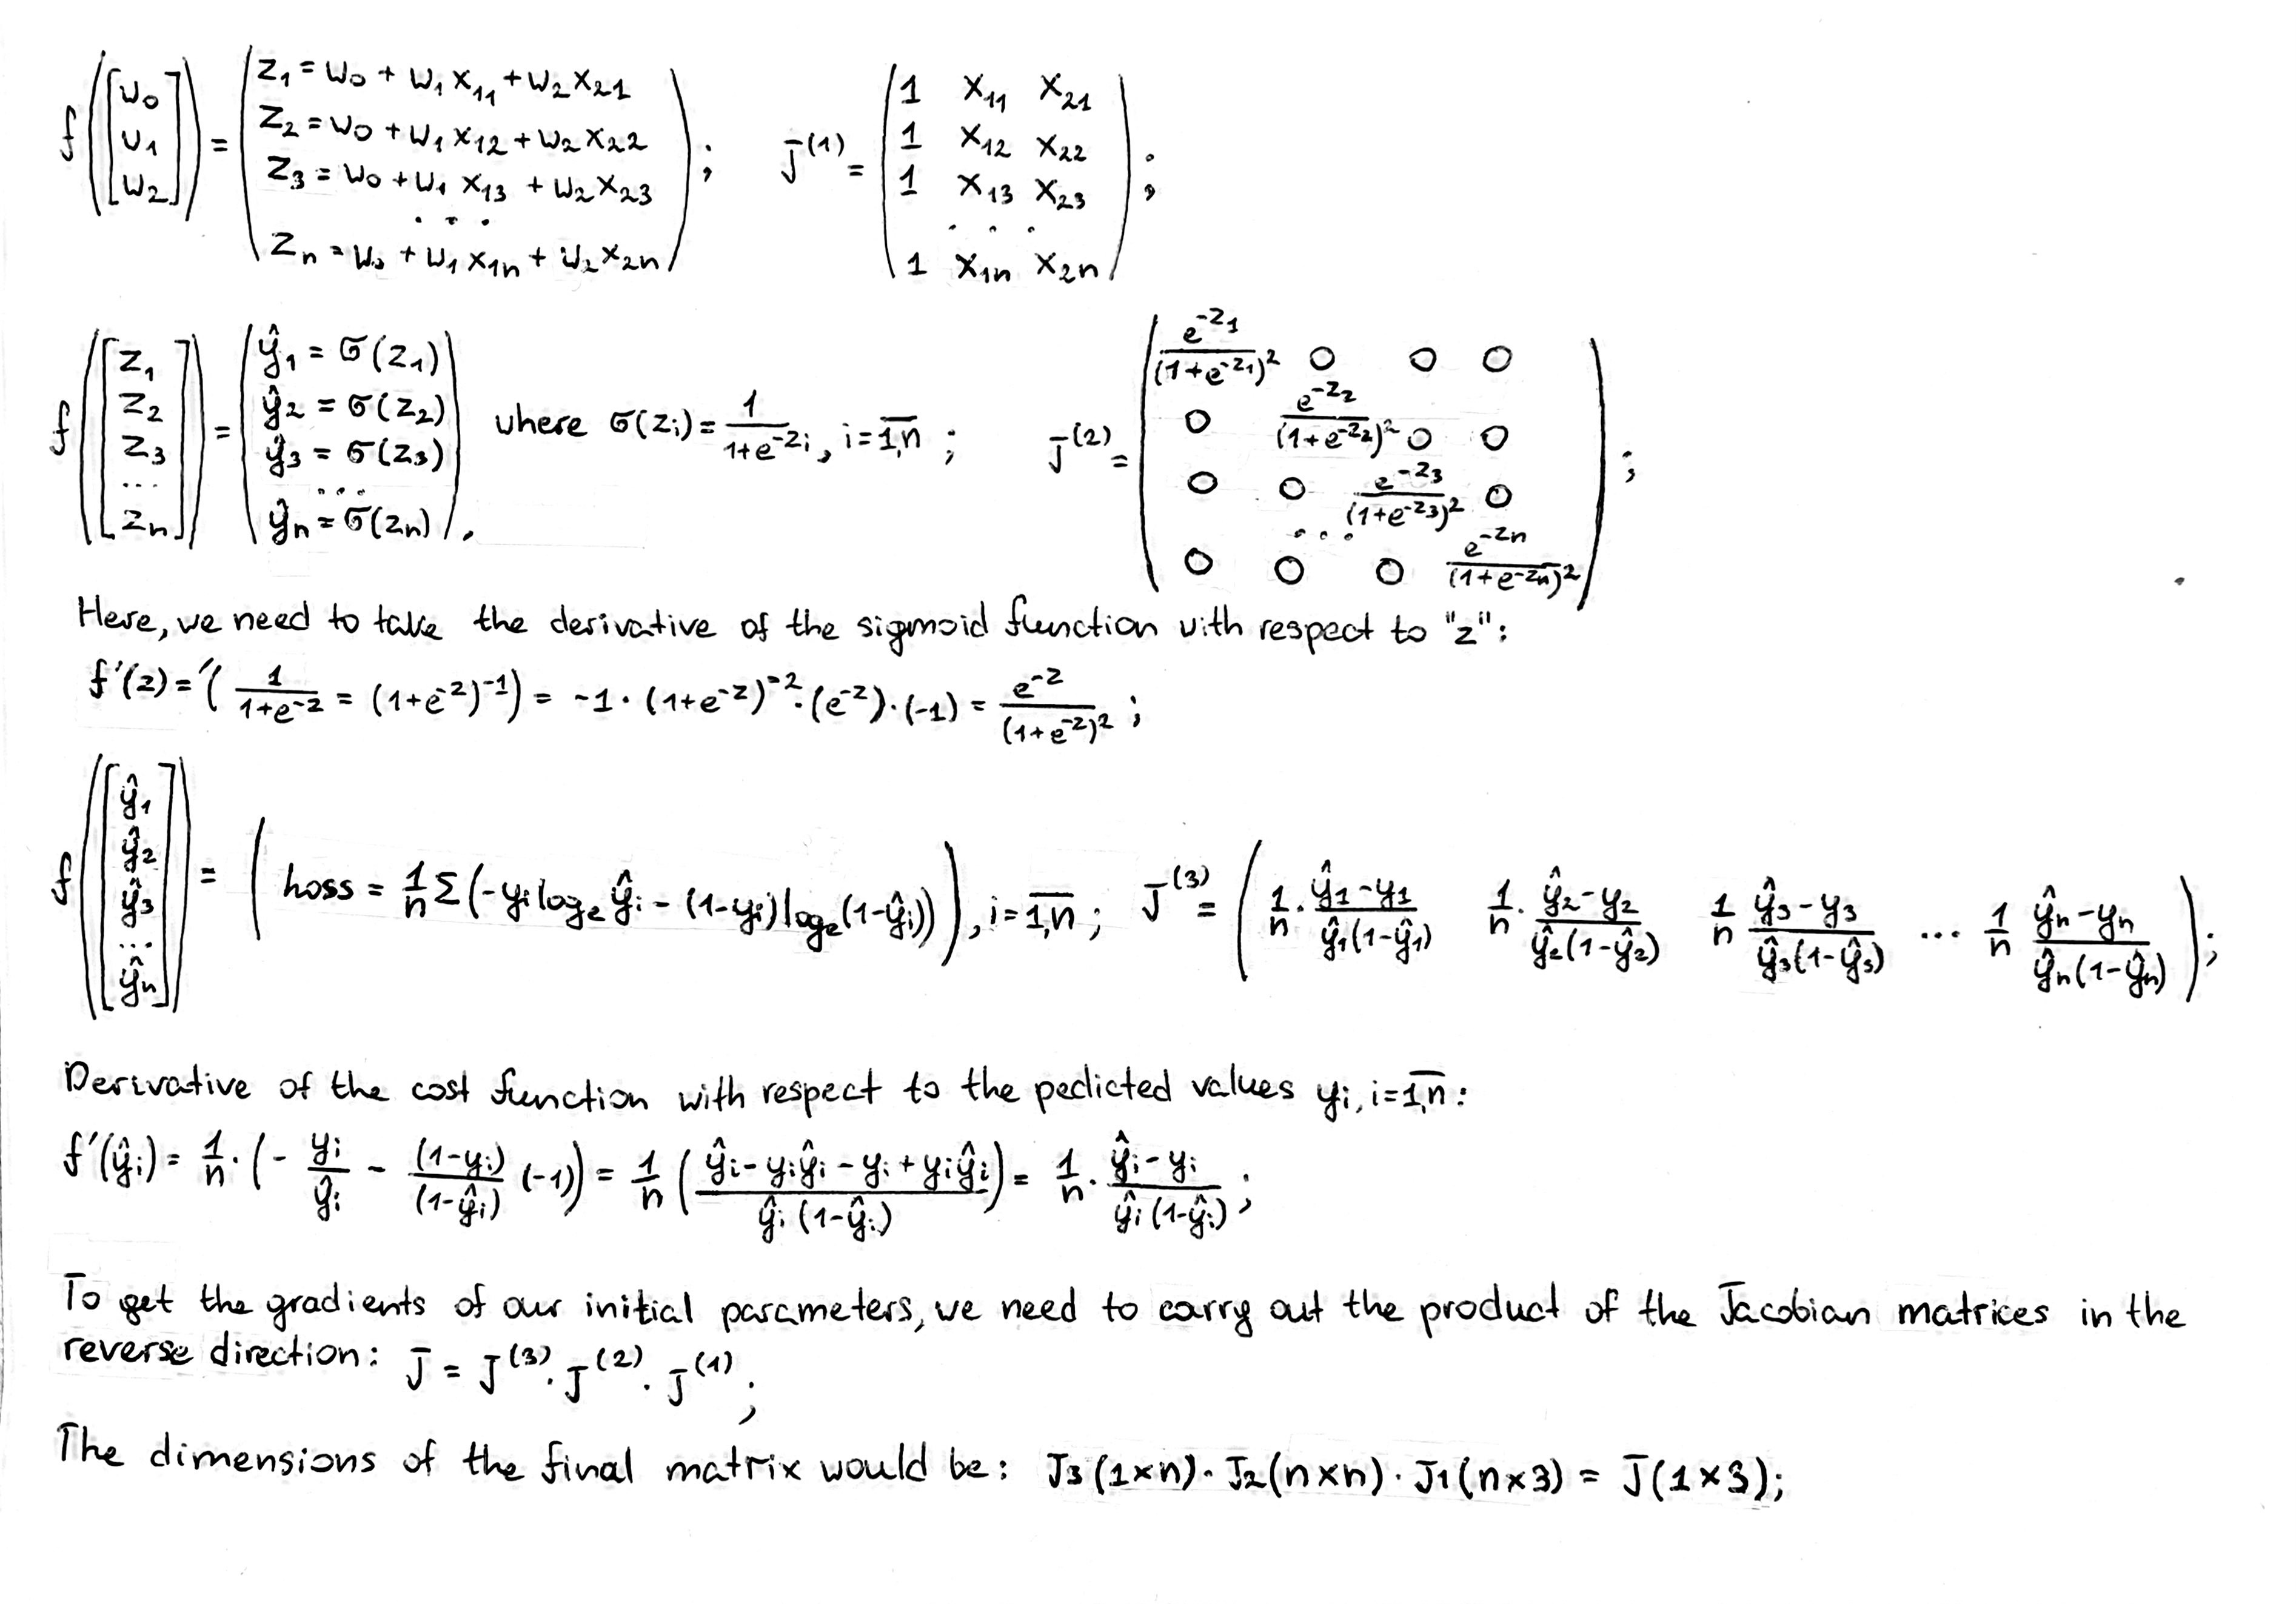

As we can see, on each step of matrices product, the  dimentions are redefined which allows us to observe how the result we are looking for is gained. This concept underlies a number of functions, like ***backward()*** funct. from **pytorch** package we we are using here:

https://pytorch.org/docs/stable/generated/torch.autograd.backward.html#torch.autograd.backward 

Let's define our parameters:

*   **w** - the weights, we are looking for;
*   **x** - the data used to estimate the model (predictors);
*   **y** - the dependent variable;



In [ ]:
#Note that we set requires_grad=True in the case of the weight tensor so that it can track the phases of the graph;
w = torch.tensor([[0.0], [0.0], [0.0]], dtype=torch.float32, requires_grad=True)
x = x_train_t
y = y_train_t.reshape(-1,1)

Before we start implementing all the calculations in the code, we need to make sure that the dimensions of the tensors are correct.

In [ ]:
print(f"shape of w: {w.shape}; x: {x.shape}; y: {y.shape}")

shape of w: torch.Size([3, 1]); x: torch.Size([320, 3]); y: torch.Size([320, 1])


In [ ]:
#The numbers next to the code correspond to the node operations mentioned in the computational graph;
z = x @ w #(1)
y_hat = torch.sigmoid(z) #(2)
loss = (- y * torch.log(y_hat) - (1 - y) * torch.log(1-y_hat)).mean()  #(3) - custom version of nn.BCELoss()

In [ ]:
#calculation of gradients with respect to graph leaves.
loss.backward() 

In [ ]:
w.grad

tensor([[ 0.0063],
        [-0.1846],
        [-0.2508]])

We also can express the value of **dw** using the formulas, we derived earlier:

In [ ]:
with torch.no_grad():
  dw0 = (x[:,0].reshape(-1, 1) * (y_hat-y)).mean()
  dw1 = (x[:,1].reshape(-1, 1) * (y_hat-y)).mean()
  dw2 = (x[:,2].reshape(-1, 1) * (y_hat-y)).mean()

In [ ]:
print(f"dw0: {dw0}; dw1: {dw1}; dw2: {dw2};")

dw0: 0.0062500000931322575; dw1: -0.18456122279167175; dw2: -0.2507587969303131;


To adjust our weights, we need to subtract the gradient from the **w** tensor; but before we do that, we need to set the so-called ***learning rate***. The idea behind this parameter is that it determines the magnitude of step at each iteration.

**High learning rate** allows the model to learn faster; In theory, this allows the global minimum to be reached in fewer iterations; But it is not always the case. When the steps are too large, it can interfere with convergence at the optimum point and risk overshoot.

While a **low learning rate** suggests a more optimal way to train the model, but significantly increases the number of iterations. The problem we might run into here is that, in light of the previous data transformations, an excessive number of iterations may be required due to the tiny weight updates. In some cases 20.000 - 30.000 epochs won't work.

So we have to take into account the scale of data, try multiple values to select the optimal learning rate and use estimated cost function as indicator of the model training. (Below, I will consider some of the expects I mentioned here).

Let`s use the **automated software** here, as an example we will rely on in the comparison of the results:

In [ ]:
#Note that regularization is applied by default; To remove it, we need to set: penalty='none'
model = LogisticRegression(penalty='none', max_iter = 4000, solver='newton-cg').fit(x_train[:,[1,2]], y_train)

In [ ]:
print(f"Estimated coefficients: intercept {model.intercept_}; w1 {model.coef_[:,0]}; w2 {model.coef_[:,1]}")

Estimated coefficients: intercept [-0.06878692]; w1 [1.14345041]; w2 [1.58352602]


Now let's **put your approach into practice**. To do this, we redefine our variables, put the optimization algorithm inside the loop and wrap it all in a custom procedure. The last step is optional, but we want to avoid code duplication. That is why we implement this block in this way.

In [ ]:
w = torch.tensor([[0.0], [0.0], [0.0]], dtype=torch.float32, requires_grad=True)
x = x_train_t
y = y_train_t.reshape(-1,1)

In [ ]:
lr = 0.1 #learning rate
cost_f = np.array([]) #array to collect cost function values

In [ ]:
def model_training(w, x, y, lr, cost_f, num_iter = 4000):

  for epoch in range(num_iter):
    z = x @ w
    y_hat = torch.sigmoid(z)
    loss = (- y * torch.log(y_hat) - (1 - y) * torch.log(1-y_hat)).mean()

    loss.backward()

    with torch.no_grad():
      #update weights
      w -=  lr * w.grad
      #collect the value of cost function
      cost_f = np.append(cost_f, loss)

    #empty the gradients to provide the next iterantion step
    w.grad.zero_()

  return cost_f, w


Note, that the tensor of weights preserve the changes and there is no need to return it. But it is rather an exception than the rule, so we will follow the common practice.

In [ ]:
cost_f, w = model_training(w, x, y, lr, cost_f)

In [ ]:
w

tensor([[-0.0688],
        [ 1.1434],
        [ 1.5835]], requires_grad=True)

As we can see, we got the same results. Note that the algorithm used in the LogisticRegression function is different. The reason is that there is a huge variety of optimization algorithms that can be used to find parameters. Most of them are gradient based, as is the method we used: Newton-CG. They may be more efficient in comparison with the SGD - Stochastic gradient descent, we provided here, but the result must be the same. Thus, we can say that we made a double-check and we are confident in our estimates.

Let's plot the cost function values we have collected to represent the process of training.

In [ ]:
# using ggplot style is a habit from R;
style.use('ggplot')

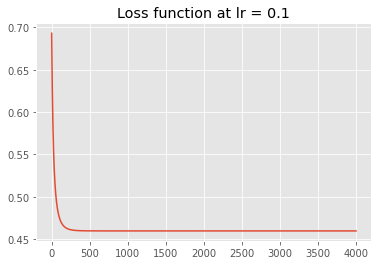

In [ ]:
plt.title("Loss function at lr = 0.1")
plt.plot(cost_f)

As is evident from the plot, the loss decreased significantly in the first 200 iterations. Than it began the reduction, but the scale of change became tiny. That is why the rest part of plot resembles an elongated horizontal line (which is not indeed). The **update will be performed until the moment**, we reach the global minimum, or will be such close to it, that the gradient multiplied by the learning rate will give almost no result.

Let`s change the value of the learning rate to 0.01 and conduct the same operation.

In [ ]:
w = torch.tensor([[0.0], [0.0], [0.0]], dtype=torch.float32, requires_grad=True)
x = x_train_t
y = y_train_t.reshape(-1,1)

In [ ]:
lr = 0.01 #learning rate
cost_f = np.array([]) #array to collect cost function values

In [ ]:
cost_f, w = model_training(w, x, y, lr, cost_f)

In [ ]:
#estimated coefficients
w

tensor([[-0.0637],
        [ 1.1011],
        [ 1.5250]], requires_grad=True)

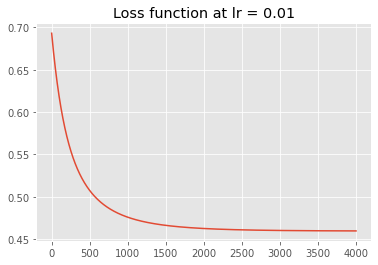

In [ ]:
plt.title("Loss function at lr = 0.01")
plt.plot(cost_f)

The slope is smoother, which is explained by the size of the steps. There is no longer a "straight line" on the horizontal axis. Moreover, according to the array of weights (**w**) - the coefficients are not fully optimized. This is the case, we described in the theoretical section above.

**But what is the reason?**

Despite the fact that we change learning rate from 0.1 to 0.01, we have to remember, that we changed the scale of the data itself through regularization. If the influence of this factor is not obvious in current representation, let us recall the formulas that we obtained by doing all the calculations manually:

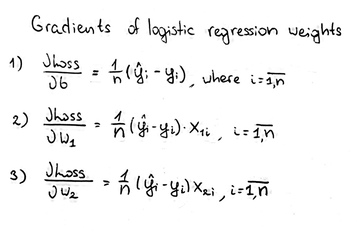

So we also have to take into account the scale of data we are working with.

**We have already finished the main part** of logistic regression optimization using the approach that neural networks use. In the current view, we have tried to avoid automatic functions where possible to provide an intuitive understanding of how models are trained. But in practice, we will rather refer to well-known packages and their functionality than to write all these commands and formulas by hand.

Thus, this part of section 3.1 dedicated to **classical way of model construction** in python.

In [ ]:
x = x_train_t[:,[1,2]]
y = y_train_t.reshape(-1,1)

In [ ]:
class LogisticReg(nn.Module): #(1)
  def __init__(self, n_features_f):
    super(LogisticReg, self).__init__()
    self.linear = nn.Linear(n_features_f, 1)

    with torch.no_grad():
        self.linear.weight.copy_(torch.zeros(1))
        self.linear.bias.copy_(torch.zeros(1))

  def forward(self, x):
    y_pred = torch.sigmoid(self.linear(x))
    return(y_pred)

In [ ]:
n_features = x.shape[1]

In [ ]:
#creating an instance of a class "LogisticReg";
model = LogisticReg(n_features)

#create loss and optimizer:
loss = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
for epoch in range(4000):
  #forward pass;
  y_hat = model.forward(x)
  
  #compute the loss and perform backpropagation;
  Loss = loss(y_hat, y).backward()

  #updates;
  optimizer.step()

  #empty gradients;
  optimizer.zero_grad()

In [ ]:
#let`s derive the estimated coefficients and represent them in a more convenient way;
torch.hstack((model.linear.bias.reshape(-1,1), model.linear.weight)).detach()

tensor([[-0.0688,  1.1434,  1.5835]])

After completion of model training on the training set, we can use estimated coefficients to find the predicted values for our test set, we prepared earlier.
Then we will use accurecy as the main indicator of model performance. In order to do this we need to find the ROC curve that determines the right threshold for dependent variable classification.

We will not go into the details of confusion matrices, ROC curves, and related terminology—that is beyond the scope of this chapter. But it is extremely helpful to understand the idea behind this to ensure the quality of the analysis.

In [ ]:
#predicted values of the training set;
y_hat = model.forward(x).detach()
#components of the ROC curve;
fpr, tpr, threshold = metrics.roc_curve(y,  y_hat)

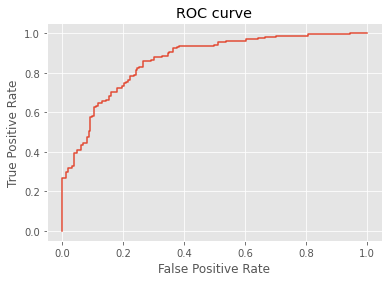

In [ ]:
plt.title("ROC curve")
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

There is no single way to determine the optimal threshold. Depending on which parameter we want to maximize, we can choose a specific one among the variety of methods. But the most general approach is to use the **Youden's J-statistic**, the implementation of which is given below:

In [ ]:
idx = np.argmax(tpr - fpr)
opt_p = threshold[idx]
print(f'The optimal threshold is {opt_p}' )

The optimal threshold is 0.4146195650100708


Finally, we can test the performance of the model using the **training set** and **test set**, given the optimal threshold for classifying binary variables:

**Training set:**

In [ ]:
#getting the predicted values;
y_hat = model.forward(x).detach()

#round them with respect to optimal threshold;
y_hat = torch.round((y_hat - opt_p + 0.5))

#create the confusion matrix;
metrics.confusion_matrix(y, y_hat)

array([[119,  43],
       [ 23, 135]])

In [ ]:
#The prediction accuracy
metrics.accuracy_score(y, y_hat)

0.79375

**Test set:**

In [ ]:
x_2 = x_test_t[:,[1,2]]
y_2 = y_test_t.reshape(-1,1)

In [ ]:
#getting the predicted values;
y_hat2 = model.forward(x_2).detach()

#round them with respect to optimal threshold;
y_hat2 = torch.round((y_hat2 - opt_p + 0.5))

#create the confusion matrix;
metrics.confusion_matrix(y_2, y_hat2)

array([[30,  8],
       [ 7, 35]])

In [ ]:
#The prediction accuracy
metrics.accuracy_score(y_2, y_hat2)

As we can see, the model accuracy when using the test sample is 81% (65 labels out of 80 are correctly identified). Whereas, in the case of training set the accuracy is a little bit lower (79% of labels indentified correctly).

**Summary**

At was mentioned at the beginning, the purpose of this chaptes is to cover the idea behind neural networks training. We started from the theory block, which formed the basic intuition of the process inside. On its basis, we also rebuilt the logistics model, avoiding automated software where possible. As we delved deeper into the topic, we improved the code and identified the main factors that can affect the effectiveness of stochastic gradient descent optimization. We showed in practice the importance of the data scale and learning rate, revealed the concept of a computational graph and the product of Jacobi matrices.

Closer to the end of the chapter, we recreated the model for the third time, using the classical way of model construction in python. The prevoius examples were rather a learning material, than a model itself. The results of our models matched the results of the proposed automated solution.

Despite the fact, that the further analysis is beyond the scope of this chapter, I have decided to complete it. The ROC-curve, optimal threshold and confusion matrices were found. The main parameter of the model quality was the accuracy, the value of which was 79% and 81% for the training and test sets, respectively.